Begun 3/26/24

Based on the results in nb7 (finding that the remaining bias seemed to have to do with the covariance weighting), we want to test in this notebook whether the estimator is unbiased when a realistic noise profile is added. I will calculate the noise power spectra from a single depth-1 map (which will just be the autospectra since they are noise dominated maps) and use that to generate a new noise map for every iteration that we can add to the realization of the signal map.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pixell import enmap, enplot, reproject, utils, curvedsky
from tqdm import tqdm
import nawrapper as nw
import yaml
import time
import healpy as hp

In [39]:
# Load CAMB spectra
ell_camb,DlTT_camb,DlEE_camb,DlBB_camb,DlTE_camb = np.loadtxt( \
            "/home/zbh5/act_analysis/act_axion_analysis/resources/camb_19413797_lensedtotcls.dat", \
                                                              usecols=(0,1,2,3,4), unpack=True) 
# Note that ell_camb runs from 2 to 5400
# Healpy expects ell to start at zero
# Initializing new arrays with first two entries set to zero
arr_len = ell_camb.size+2
ell = np.zeros(arr_len)
ell[1] = 1
ell[2:] = ell_camb
ClTT = np.zeros(arr_len)
ClEE = np.zeros(arr_len)
ClTE = np.zeros(arr_len)
ClBB = np.zeros(arr_len)
# convert Dl to Cl
ClTT[2:] = DlTT_camb * 2 * np.pi / (ell_camb*(ell_camb+1.))
ClEE[2:] = DlEE_camb * 2 * np.pi / (ell_camb*(ell_camb+1.))
ClTE[2:] = DlTE_camb * 2 * np.pi / (ell_camb*(ell_camb+1.))
ClBB[2:] = DlBB_camb * 2 * np.pi / (ell_camb*(ell_camb+1.))

In [3]:
# Functions to calculate likelihood and fit for angle
# These are the only things being tested by these full sky sims at different rotation angles
def estimator_likelihood(angle, estimator, covariance, ClEE):
    """For a given difference in angle between the depth-1 map (map 1) and the coadd (map 2),
       returns the value of the normalized likelihood for our estimator.
       
       ClEE is the theory EE spectrum from CAMB"""

    numerator = (estimator - ClEE*np.sin(2*angle))**2
    denominator = 2*covariance
    likelihood = np.exp(-np.sum(numerator/denominator))
    return likelihood

def null_eb_estimator_likelihood(angle,eb,ee,bb,ClEE):
    """Returns null EB estimator from Keating et al
       eb, ee, and bb are the autospectra from the rotated map in question
       ClEE is the CAMB EE spectrum"""
    numerator = (eb+0.5*ClEE*np.sin(4*angle))**2
    denominator = 2*(ee*bb+eb**2) # Taken from A7 in the Das et al (2011) appendix - 
    # reduces to Keating term in noiseless regime if neglecting sky area factor but not the EB contribution
    likelihood = np.exp(-np.sum(numerator/denominator))
    return likelihood

def gaussian_fit_moment(angles,data):
    """
       Uses moments to quickly find mean and standard deviation of a Gaussian
       for the likelihood.
    """
    mean = np.sum(angles*data)/np.sum(data)
    std_dev = np.sqrt(abs(np.sum((angles-mean)**2*data)/np.sum(data)))
    return mean, std_dev
    
def sample_likelihood_and_fit(estimator,covariance,theory_ClEE,angle_min_deg=-20.0,angle_max_deg=20.0,num_pts=10000):
    """
       Samples likelihood for a range of angles and returns the best fit for the
       mean and median of the resulting Gaussian.  
    """
    if(angle_min_deg >= angle_max_deg): 
        raise ValueError("The min angle must be smaller than the max!")
    angles_deg = np.linspace(angle_min_deg,angle_max_deg,num=num_pts)
    angles_rad = np.deg2rad(angles_deg)
    
    bin_sampled_likelihood = [estimator_likelihood(angle,estimator,covariance,theory_ClEE) for angle in angles_rad]
    norm_sampled_likelihood = bin_sampled_likelihood/np.max(bin_sampled_likelihood)
    
    # Switching back to fitting in radians, which I think is more correct. Forgot to do in nb4
    mean, std_dev = gaussian_fit_moment(angles_rad,norm_sampled_likelihood)
    mean *= 180./np.pi
    std_dev *= 180./np.pi
    fit_values = (mean,std_dev)
    
    return fit_values

def sample_null_eb_likelihood_and_fit(eb,ee,bb,theory_ClEE,angle_min_deg=-20.0,angle_max_deg=20.0,num_pts=10000):
    """
       Samples null eb likelihood for a range of angles and returns the best fit for the
       mean and median of the resulting Gaussian.  
    """
    if(angle_min_deg >= angle_max_deg): 
        raise ValueError("The min angle must be smaller than the max!")
    angles_deg = np.linspace(angle_min_deg,angle_max_deg,num=num_pts)
    angles_rad = np.deg2rad(angles_deg)
    
    bin_sampled_likelihood = [null_eb_estimator_likelihood(angle,eb,ee,bb,theory_ClEE) for angle in angles_rad]
    norm_sampled_likelihood = bin_sampled_likelihood/np.max(bin_sampled_likelihood)
    
    mean, std_dev = gaussian_fit_moment(angles_rad,norm_sampled_likelihood)
    mean *= 180./np.pi
    std_dev *= 180./np.pi
    fit_values = (mean,std_dev)
    
    return fit_values

In [4]:
def calc_rho_mapspace(rot_Q,rot_U,unrot_Q,unrot_U):
    """
    Uses the Keck map space estimator for the angle (neglecting in-pixel correlations between Q and U)
    This estimator has been adjusted to use the same coordinate system as our angle estimator.
    It also has a factor of 2 difference because of how Q and U are defined relative to the power spectrum estimator.
    """
    rho = np.sum((-1*unrot_Q*unrot_U + rot_Q*unrot_U)+(-1*unrot_Q*rot_U + unrot_Q*unrot_U))/np.sum(unrot_U**2+unrot_Q**2)
    rho /= 2.0 # To measure the same angle as the PS estimators
    rho *= 180./np.pi
    return rho

In [19]:
def make_tapered_mask(map_to_mask,filter_radius=1.0,plot=False):
    """
        Makes a mask for a given map based on where the ivar map is nonzero.
        Also apodizes the mask and gets the indices of where the apodized
        mask is not equal to one (everything tapered or outside the mask)
        in order to set all points but those to zero after filtering.
    """
    footprint = 1*map_to_mask.astype(bool)
    mask = nw.apod_C2(footprint,filter_radius)
    
    # Getting points to set to zero after filtering
    indices = np.nonzero(mask != 1)
    
    if plot:
        eshow(mask, **keys_eshow)
    
    return mask, indices

def load_and_filter_depth1_with_T(depth1_path, plot=False):
    print(depth1_path)
    depth1_maps = enmap.read_map(depth1_path)
    ivar_path = depth1_path[:-8] + "ivar.fits"
    depth1_ivar = 0.5*enmap.read_map(ivar_path) # 0.5 for polarization noise
        
    # Apodize and filter depth-1
    depth1_mask, depth1_indices = make_tapered_mask(depth1_ivar,filter_radius=1.0,plot=plot)
    depth1_TEB = enmap.map2harm(depth1_maps*depth1_mask, normalize = "phys")
    
    w2 = np.mean(depth1_mask**2)
        
    # Not sure if I need this, but it is the default behavior in kfilter_map in nawrapper
    if unpixwin:  # remove pixel window in Fourier space
        for i in range(len(depth1_maps)):
            wy, wx = enmap.calc_window(depth1_maps[i].shape)
            depth1_TEB[i] /= wy[:, np.newaxis]
            depth1_TEB[i] /= wx[np.newaxis, :]
        
    ly, lx = depth1_TEB.lmap()
    kfilter_x = np.abs(lx) >= kx_cut
    kfilter_y = np.abs(ly) >= ky_cut
    filtered_TEB = depth1_TEB * kfilter_x * kfilter_y
    
    return filtered_TEB[0], filtered_TEB[1], filtered_TEB[2], w2

def spectrum_from_maps(map1, map2, b_ell_binned, w2, lmax, bin_size):
    """Function modified from the one in ACT DR4/5 NB7 for binning a power spectrum for two maps.
       This function does account for a window correction for the apodizing at this point.
       Also accounts for a beam correction using a beam defined by b_ell.
    """
    spectrum = np.real(map1*np.conj(map2))
    
    # Dividing by an approx. correction for the loss of power from tapering
    spectrum /= w2
    
    modlmap = map1.modlmap()

    # Define the bins and bin centers
    bins = np.arange(0, lmax, bin_size)
    centers = (bins[1:] + bins[:-1])/2.

    # Bin the power spectrum 
    digitized = np.digitize(np.ndarray.flatten(modlmap), bins, right=True)
    bincount = np.bincount(digitized)[1:-1]
    binned = np.bincount(digitized, spectrum.reshape(-1))[1:-1]/bincount

    binned /= b_ell_binned**2

    return centers, binned, bincount

In [21]:
# Loading in depth-1 map, calculating power spectra without filtering to get noise, and
# fitting an interpolation to get a spectrum for every ell with which to generate noise maps
obs_list = "/home/zbh5/act_analysis/dr6_analysis/dr6_depth1_maps/dr6_depth1_test_map_list.txt"
with open(obs_list) as f:
    lines = f.read().splitlines()

unpixwin = True
kx_cut = 90
ky_cut = 50
lmax = 2500
bin_size = 25
    
depth1_path = '/home/zbh5/act_analysis/dr6_analysis/dr6_depth1_maps/' + lines[0]

depth1_T, depth1_E, depth1_B, w2 = load_and_filter_depth1_with_T(depth1_path)

# Doing filtering and binning as normal
ell_b, depth1_TT, bincount = spectrum_from_maps(depth1_TEB[0],depth1_TEB[0],1.0,w2,lmax,bin_size)
_, depth1_EE, _ = spectrum_from_maps(depth1_TEB[1],depth1_TEB[1],1.0,w2,lmax,bin_size)
_, depth1_BB, _ = spectrum_from_maps(depth1_TEB[2],depth1_TEB[2],1.0,w2,lmax,bin_size)

/home/zbh5/act_analysis/dr6_analysis/dr6_depth1_maps/depth1_1494463440_pa4_f150_map.fits


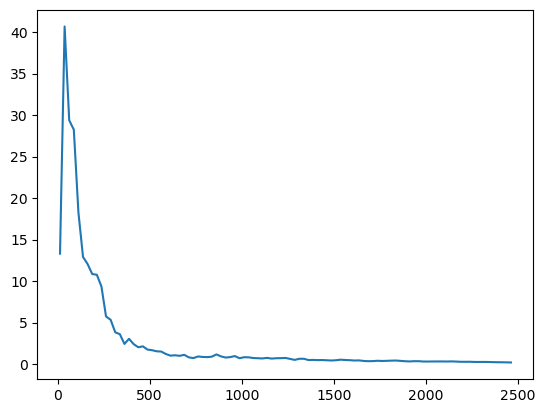

In [24]:
plt.plot(ell_b,depth1_BB)

In [25]:
# Interpolating noise data to fill every ell to put into synfast
from scipy.interpolate import CubicSpline

In [26]:
cs_TT = CubicSpline(ell_b, depth1_TT)
cs_EE = CubicSpline(ell_b, depth1_EE)
cs_BB = CubicSpline(ell_b, depth1_BB)

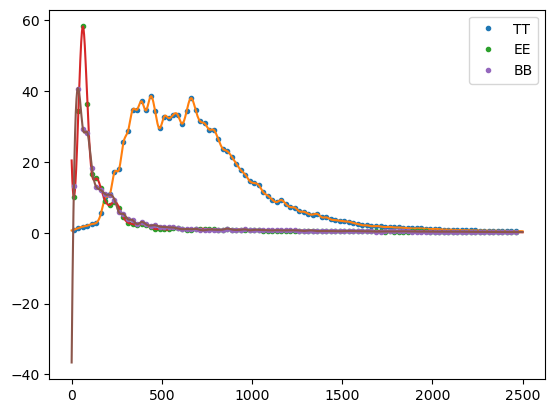

In [38]:
ell_test = np.arange(0,2501)
plt.plot(ell_b,depth1_TT, marker=".", ls="none",label = "TT")
plt.plot(ell_test, cs_TT(ell))
plt.plot(ell_b,depth1_EE, marker=".", ls="none",label = "EE")
plt.plot(ell_test, cs_EE(ell))
plt.plot(ell_b,depth1_BB, marker=".", ls="none",label = "BB")
plt.plot(ell_test, cs_BB(ell))
plt.legend()
plt.show()
plt.close()

In [42]:
noise_TT = np.zeros(arr_len)
noise_EE = np.zeros(arr_len)
noise_BB = np.zeros(arr_len)
noise_TT[2:] = cs_TT(ell[2:])
noise_EE[2:] = cs_EE(ell[2:])
noise_BB[2:] = cs_BB(ell[2:])

In [43]:
noise_TT

array([ 0.00000000e+00,  0.00000000e+00,  6.93022821e-01, ...,
       -5.44505163e+03, -5.45056273e+03, -5.45607756e+03])

In [58]:
# Doing 300 sims of full sky maps with an ell range of 200-1000 with a constant angle of 1 deg to
# test the amount of scatter for a fixed angle.
# Also calculating EB angles using unrotated spectra to make sure the distribution is unbiased there
# Also uses an estimator in map space to calculate angles

# The new thing here is generating a random noise realization from the noise spectra (no TE spectra - just pass None)
# and adding the noise map to the sim maps before rotation and attempting to recover the angle.
min_ell = 200
max_ell = 1000
N_sims = 300
nside = 512
npix = nside**2*12
print(hp.nside2resol(nside,arcmin=True))

output_angles = []
output_mapspace_angles = []
output_null_eb_angles = []
output_unrot_null_eb_angles = []
output_spectra = []
tt_bias_outputs = []

rot_degs = np.array(N_sims*[1.0])
#print("Input angles are: " + str(rot_degs))
for rot_deg in tqdm(rot_degs):
    unrot_sim_maps = hp.sphtfunc.synfast((ClTT,ClTE,ClEE,ClBB),nside)
    noise_maps = hp.sphtfunc.synfast((noise_TT, None, noise_EE, noise_BB),nside)
    # Adding noise to sims before rotating
    unrot_sim_maps = (unrot_sim_maps[0]+noise_maps[0],unrot_sim_maps[1]+noise_maps[1],unrot_sim_maps[2]+noise_maps[2])
    CMB_Q = unrot_sim_maps[1]
    CMB_U = unrot_sim_maps[2]
    rot_Q_map =  np.cos(np.deg2rad(2*rot_deg))*CMB_Q + np.sin(np.deg2rad(2*rot_deg))*CMB_U
    rot_U_map = -np.sin(np.deg2rad(2*rot_deg))*CMB_Q + np.cos(np.deg2rad(2*rot_deg))*CMB_U
    rot_sim_maps = (unrot_sim_maps[0],rot_Q_map,rot_U_map)
    mapspace_angle = calc_rho_mapspace(rot_Q_map, rot_U_map, CMB_Q, CMB_U)
    output_mapspace_angles.append(mapspace_angle)
    spectra_rotated = hp.sphtfunc.anafast(rot_sim_maps, map2=rot_sim_maps)
    spectra_unrotated = hp.sphtfunc.anafast(unrot_sim_maps, map2=unrot_sim_maps)
    spectra_cross21 = hp.sphtfunc.anafast(unrot_sim_maps, map2=rot_sim_maps)
    spectra_cross12 = hp.sphtfunc.anafast(rot_sim_maps, map2=unrot_sim_maps)
    
    # Calculating spectra
    ell_hp = np.arange(spectra_rotated[0].size)
    
    ClTT_rot = spectra_rotated[0][min_ell:max_ell] 
    ClEE_rot = spectra_rotated[1][min_ell:max_ell] 
    ClBB_rot = spectra_rotated[2][min_ell:max_ell] 
    ClTE_rot = spectra_rotated[3][min_ell:max_ell] 
    ClEB_rot = spectra_rotated[4][min_ell:max_ell] 
    ClTB_rot = spectra_rotated[5][min_ell:max_ell] 
    
    ClTT_unrot = spectra_unrotated[0][min_ell:max_ell]
    ClEE_unrot = spectra_unrotated[1][min_ell:max_ell]
    ClBB_unrot = spectra_unrotated[2][min_ell:max_ell]
    ClTE_unrot = spectra_unrotated[3][min_ell:max_ell]
    ClEB_unrot = spectra_unrotated[4][min_ell:max_ell]
    ClTB_unrot = spectra_unrotated[5][min_ell:max_ell]
    
    ClTT_cross12 = spectra_cross12[0][min_ell:max_ell]
    ClEE_cross12 = spectra_cross12[1][min_ell:max_ell]
    ClBB_cross12 = spectra_cross12[2][min_ell:max_ell]
    ClTE_cross12 = spectra_cross12[3][min_ell:max_ell]
    ClEB_cross12 = spectra_cross12[4][min_ell:max_ell]
    ClTB_cross12 = spectra_cross12[5][min_ell:max_ell]
    
    ClTT_cross21 = spectra_cross21[0][min_ell:max_ell]
    ClEE_cross21 = spectra_cross21[1][min_ell:max_ell]
    ClBB_cross21 = spectra_cross21[2][min_ell:max_ell]
    ClTE_cross21 = spectra_cross21[3][min_ell:max_ell]
    ClEB_cross21 = spectra_cross21[4][min_ell:max_ell]
    ClTB_cross21 = spectra_cross21[5][min_ell:max_ell]
    
    spectra = [ClTT_rot,ClEE_rot,ClBB_rot,ClTE_rot,ClEB_rot,ClTB_rot,
               ClTT_unrot,ClEE_unrot,ClBB_unrot,ClTE_unrot,ClEB_unrot,ClTB_unrot,
               ClTT_cross12,ClEE_cross12,ClBB_cross12,ClTE_cross12,ClEB_cross12,ClTB_cross12,
               ClTT_cross21,ClEE_cross21,ClBB_cross21,ClTE_cross21,ClEB_cross21,ClTB_cross21]
    output_spectra.append(spectra) # Saving all spectra for analyzing them afterwards
    
    ell_hp = ell_hp[min_ell:max_ell]
    
    estimator = ClEB_cross12 - ClEB_cross21
    # Full sky estimator, so there is no prefactor
    covariance = ((ClEE_rot*ClBB_unrot+ClEB_cross12**2) \
                  + (ClEE_unrot*ClBB_rot+ClEB_cross21**2) \
                  - 2*(ClEE_cross12*ClBB_cross12+ClEB_rot*ClEB_unrot))
    
    # Using the same angle range and num_pts as Steve's last test
    fit_values = sample_likelihood_and_fit(estimator,covariance,ClEE[min_ell:max_ell],\
                                           angle_min_deg=0.0,angle_max_deg=2.0,num_pts=1000)
    null_eb_fit_values = sample_null_eb_likelihood_and_fit(ClEB_rot,ClEE_rot,ClBB_rot,ClEE[min_ell:max_ell],\
                                                          angle_min_deg=0.0,angle_max_deg=2.0,num_pts=1000)
    # This one should be centered around 0, not the input angle
    unrot_null_eb_fit_values = sample_null_eb_likelihood_and_fit(ClEB_unrot,ClEE_unrot,ClBB_unrot,ClEE[min_ell:max_ell],\
                                                          angle_min_deg=-1.0,angle_max_deg=1.0,num_pts=1000)
    #print("Output angle: " + str(fit_values))
    #print("Output null EB angle: " + str(null_eb_fit_values))
    tt_bias_outputs.append(np.mean(ClTT_rot/ClTT[min_ell:max_ell]))
    output_angles.append(fit_values)
    output_null_eb_angles.append(null_eb_fit_values)
    output_unrot_null_eb_angles.append(unrot_null_eb_fit_values)
    
rot_degs = np.array(rot_degs)
output_angles_only = np.array(output_angles)[:,0]
output_null_eb_angles_only = np.array(output_null_eb_angles)[:,0]
output_unrot_null_eb_angles_only = np.array(output_unrot_null_eb_angles)[:,0]
percent_diff = 100.0*(output_angles_only - rot_degs)/rot_degs
percent_diff_eb = 100.0*(output_null_eb_angles_only - rot_degs)/rot_degs

6.870972823634812


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [1:11:27<00:00, 14.29s/it]


Median of full sky percent error, map based estimator: -0.020306590798047086
Mean of full sky percent error, map based estimator: -0.020306590798045903
Std dev of full sky percent error, map based estimator: 7.976777094066766e-14


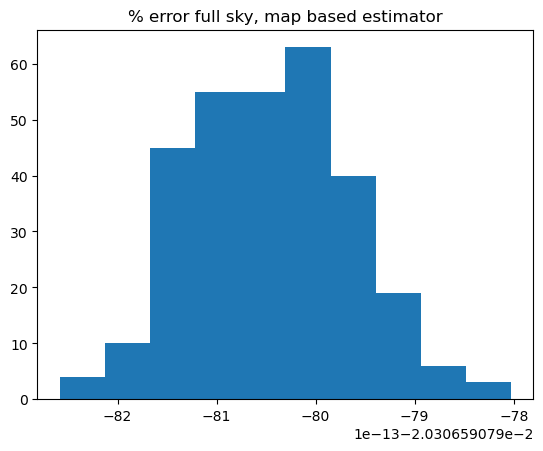

Median of full sky percent error: 0.04153317953436986
Mean of full sky percent error: 0.04588107163347628
Std dev of full sky percent error: 0.15753828808010517


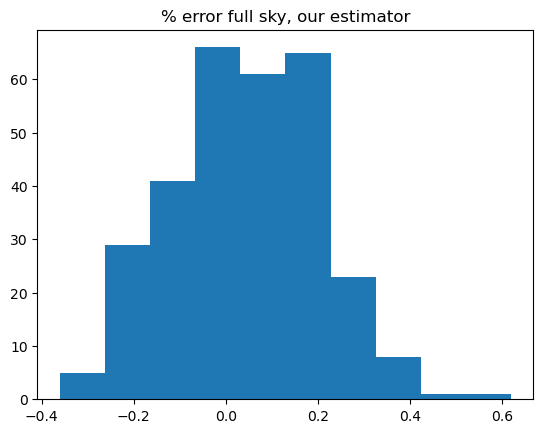

Median of full sky percent error EB estimator: -0.8792502453470963
Mean of full sky percent error EB estimator: -0.8762338494025289
Std dev of full sky percent error EB estimator: 0.2266551731490646


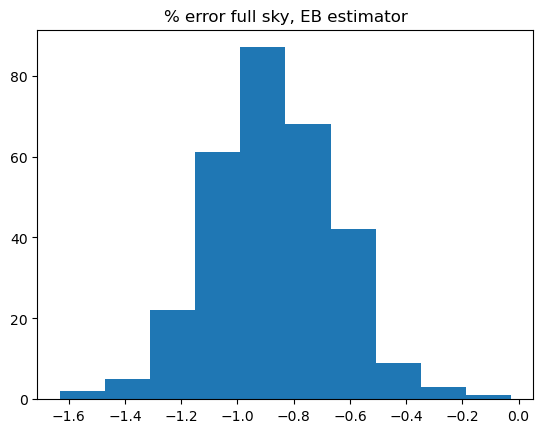

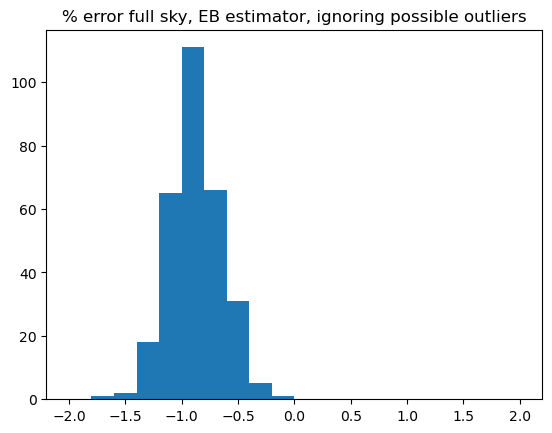

Median of full sky angles Unrot EB estimator: 6.784966464452867e-05
Mean of full sky angles Unrot EB estimator: -1.5881834055655107e-05
Std dev of full sky angles Unrot EB estimator: 0.0017434185061882279


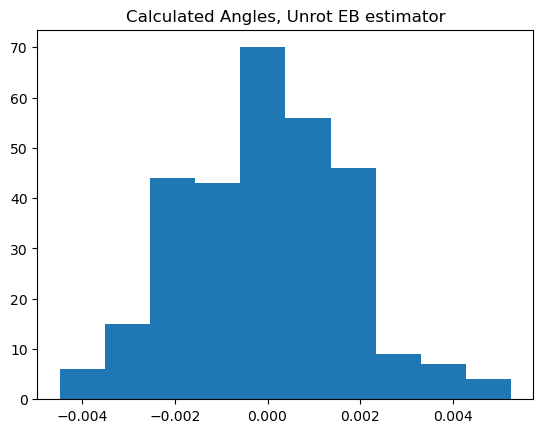

Median of full sky mean TT ratio: 0.9999947940221134
Mean of full sky mean TT ratio: 0.9999063439042243
Std dev of full sky mean TT ratio: 0.00151299543170346


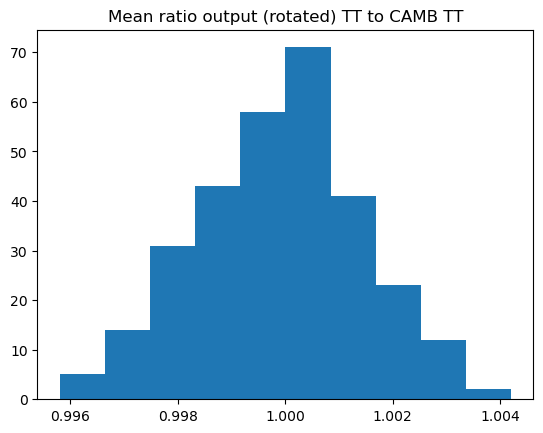

In [59]:
output_mapspace_angles = np.array(output_mapspace_angles)
mapbased_percent_diff = 100.0*(output_mapspace_angles - rot_degs)/rot_degs
print("Median of full sky percent error, map based estimator: " + str(np.median(mapbased_percent_diff)))
print("Mean of full sky percent error, map based estimator: " + str(np.mean(mapbased_percent_diff)))
print("Std dev of full sky percent error, map based estimator: " + str(np.std(mapbased_percent_diff)))
plt.hist(mapbased_percent_diff)
plt.title("% error full sky, map based estimator")
plt.show()
plt.close()

print("Median of full sky percent error: " + str(np.median(percent_diff)))
print("Mean of full sky percent error: " + str(np.mean(percent_diff)))
print("Std dev of full sky percent error: " + str(np.std(percent_diff)))
plt.hist(percent_diff)
plt.title("% error full sky, our estimator")
plt.show()
plt.close()
print("Median of full sky percent error EB estimator: " + str(np.median(percent_diff_eb)))
print("Mean of full sky percent error EB estimator: " + str(np.mean(percent_diff_eb)))
print("Std dev of full sky percent error EB estimator: " + str(np.std(percent_diff_eb)))
plt.hist(percent_diff_eb)
plt.title("% error full sky, EB estimator")
plt.show()
plt.close()
# Plotting in a limited range to ignore large outliers
plt.hist(percent_diff_eb,bins=20,range=(-2,2))
plt.title("% error full sky, EB estimator, ignoring possible outliers")
plt.show()
plt.close()
# We want to see that the distribution of unrotated angles is consistent with zero
# Don't need to calculate percent diff here
print("Median of full sky angles Unrot EB estimator: " + str(np.median(output_unrot_null_eb_angles_only)))
print("Mean of full sky angles Unrot EB estimator: " + str(np.mean(output_unrot_null_eb_angles_only)))
print("Std dev of full sky angles Unrot EB estimator: " + str(np.std(output_unrot_null_eb_angles_only)))
plt.hist(output_unrot_null_eb_angles_only)
plt.title("Calculated Angles, Unrot EB estimator")
plt.show()
plt.close()
print("Median of full sky mean TT ratio: " + str(np.median(tt_bias_outputs)))
print("Mean of full sky mean TT ratio: " + str(np.mean(tt_bias_outputs)))
print("Std dev of full sky mean TT ratio: " + str(np.std(tt_bias_outputs)))
plt.hist(tt_bias_outputs)
plt.title("Mean ratio output (rotated) TT to CAMB TT")
plt.show()
plt.close()